In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pytorch_pretrained_bert import BertTokenizer
import torch
from torch import nn
%matplotlib inline
import json
from tqdm import tqdm
from sklearn import metrics

from model import BertPunc
from data import load_file, preprocess_data, create_data_loader

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### Model path

In [2]:
glob('models/*')

['models/20190418_211742', 'models/20190419_162056']

In [3]:
path = 'models/20190419_162056/'

### Prepare

In [4]:
# data_test = load_file('data/LREC/test2011')
# data_test_asr = load_file('data/LREC/test2011asr')
data_test = load_file('data/NPR-podcasts/test')

In [5]:
with open(path+'hyperparameters.json', 'r') as f:
    hyperparameters = json.load(f)
hyperparameters

{'segment_size': 32,
 'dropout': 0.3,
 'epochs_top': 1,
 'iterations_top': 2,
 'batch_size_top': 1024,
 'learning_rate_top': 1e-05,
 'epochs_all': 4,
 'iterations_all': 3,
 'batch_size_all': 256,
 'learning_rate_all': 1e-05}

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# punctuation_enc = {
#     'O': 0,
#     'COMMA': 1,
#     'PERIOD': 2,
#     'QUESTION': 3
# }

punctuation_enc = {
    'O': 0,
    'PERIOD': 1
}

segment_size = hyperparameters['segment_size']

In [7]:
X_test, y_test = preprocess_data(data_test, tokenizer, punctuation_enc, segment_size)
# X_test_asr, y_test_asr = preprocess_data(data_test_asr, tokenizer, punctuation_enc, segment_size)

In [8]:
output_size = len(punctuation_enc)
dropout = hyperparameters['dropout']
bert_punc = nn.DataParallel(BertPunc(segment_size, output_size, dropout).cuda())

### Model progress

In [9]:
progress = pd.read_csv(path+'progress.csv', delimiter=';')
progress

,time,epoch,iteration,training loss,loss,accuracy,f1_O,f1_PERIOD
0,2019-04-19 17:13:29,1,1,0.1297,0.1167,0.9546,0.9751,0.6963
1,2019-04-19 18:05:23,1,2,0.1324,0.1110,0.9561,0.9761,0.6982
2,2019-04-19 19:39:05,1,1,0.0569,0.0740,0.9709,0.9840,0.8098
3,2019-04-19 21:13:36,1,2,0.0685,0.0682,0.9732,0.9853,0.8209
4,2019-04-19 22:48:33,1,3,0.0026,0.0683,0.9731,0.9853,0.8079


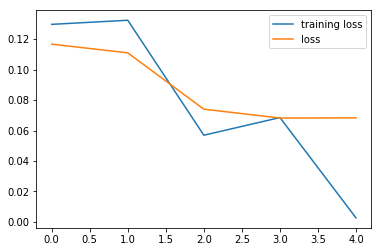

In [10]:
progress[['training loss', 'loss']].plot();

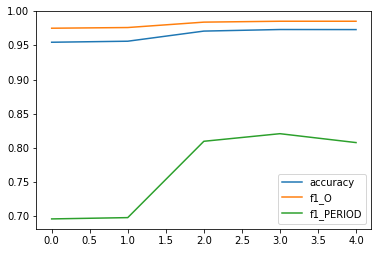

In [12]:
# progress[['accuracy', 'f1_space', 'f1_comma', 'f1_period', 'f1_question']].plot();
progress[['accuracy', 'f1_O', 'f1_PERIOD']].plot();

### Model evaluation

In [13]:
bert_punc.load_state_dict(torch.load(path+'model'))
bert_punc.eval();

In [14]:
batch_size = 1024
data_loader_test = create_data_loader(X_test, y_test, False, batch_size)
# data_loader_test_asr = create_data_loader(X_test_asr, y_test_asr, False, batch_size)

In [15]:
def predictions(data_loader):
    y_pred = []
    y_true = []
    for inputs, labels in tqdm(data_loader, total=len(data_loader)):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            output = bert_punc(inputs)
            y_pred += list(output.argmax(dim=1).cpu().data.numpy().flatten())
            y_true += list(labels.cpu().data.numpy().flatten())
    return y_pred, y_true

In [16]:
def evaluation(y_pred, y_test):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1, 2, 3])
    overall = metrics.precision_recall_fscore_support(
        y_test, y_pred, average='macro', labels=[1, 2, 3])
    result = pd.DataFrame(
        np.array([precision, recall, f1]), 
        columns=list(punctuation_enc.keys())[1:], 
        index=['Precision', 'Recall', 'F1']
    )
    result['OVERALL'] = overall[:3]
    return result

In [20]:
def evaluation(y_pred, y_test):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1])
    overall = metrics.precision_recall_fscore_support(
        y_test, y_pred, average='macro', labels=[1])
    result = pd.DataFrame(
        np.array([precision, recall, f1]), 
        columns=list(punctuation_enc.keys())[1:], 
        index=['Precision', 'Recall', 'F1']
    )
    result['OVERALL'] = overall[:3]
    return result

#### Test

In [22]:
y_pred_test, y_true_test = predictions(data_loader_test)
eval_test = evaluation(y_pred_test, y_true_test)
eval_test

100%|██████████| 260/260 [03:08<00:00,  1.19it/s]


,PERIOD,OVERALL
Precision,0.868980,0.868980
Recall,0.773116,0.773116
F1,0.818250,0.818250


In [62]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test = pd.DataFrame({
    'COMMA':    [0.655, 0.471, 0.548],
    'PERIOD':   [0.733, 0.725, 0.729],
    'QUESTION': [0.707, 0.630, 0.667],
    'OVERALL':  [0.700, 0.597, 0.644]
}, index=['Precision', 'Recall', 'F1'])
ref_test

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.655,0.733,0.707,0.700
Recall,0.471,0.725,0.630,0.597
F1,0.548,0.729,0.667,0.644


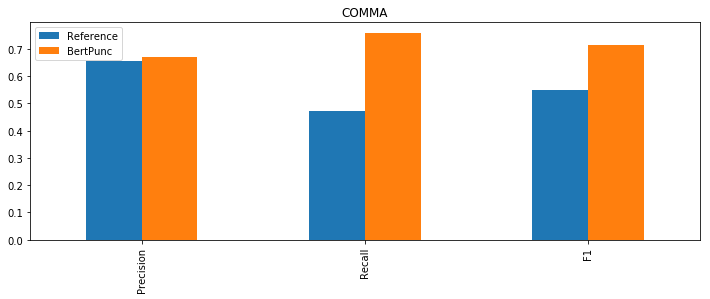

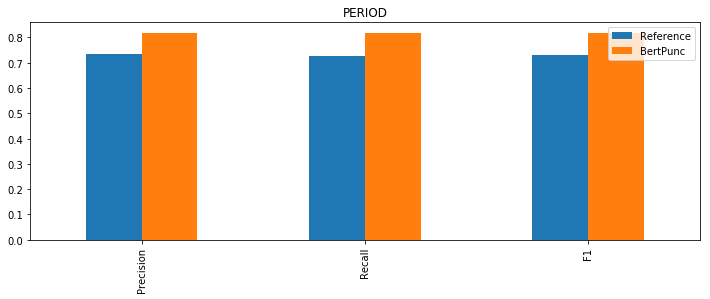

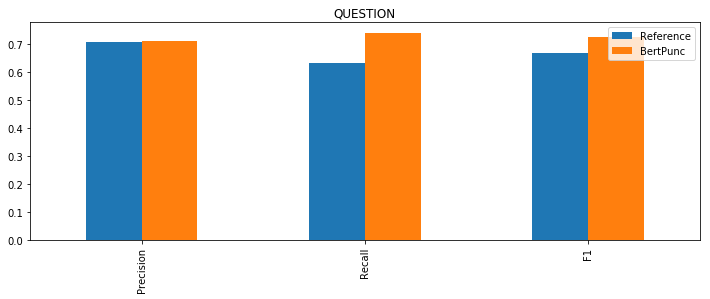

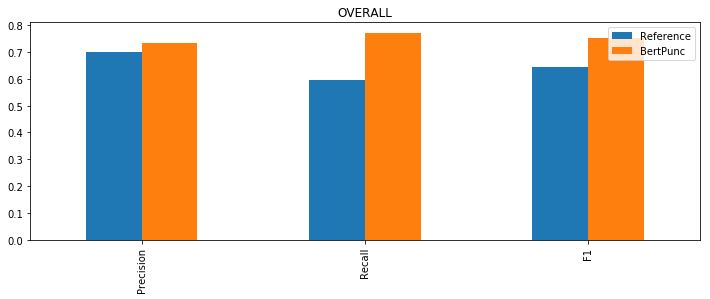

In [64]:
for col in ref.columns:
    pd.DataFrame({'Reference': ref_test[col], 'BertPunc': eval_test[col]}).plot.bar(
        title=col, figsize=(12, 4))

#### Test ASR

In [38]:
y_pred_test_asr, y_true_test_asr = predictions(data_loader_test_asr)
eval_test_asr = evaluation(y_pred_test_asr, y_true_test_asr)
eval_test_asr

100%|██████████| 14/14 [00:09<00:00,  1.71it/s]


,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.485539,0.771995,0.469388,0.575641
Recall,0.694236,0.770087,0.657143,0.707155
F1,0.571429,0.771040,0.547619,0.630029


In [65]:
# https://www.isca-speech.org/archive/Interspeech_2016/pdfs/1517.PDF
ref_test_asr = pd.DataFrame({
    'COMMA':    [0.596, 0.429, 0.499],
    'PERIOD':   [0.707, 0.720, 0.714],
    'QUESTION': [0.607, 0.486, 0.540],
    'OVERALL':  [0.660, 0.573, 0.614]
}, index=['Precision', 'Recall', 'F1'])
ref_test_asr

,COMMA,PERIOD,QUESTION,OVERALL
Precision,0.596,0.707,0.607,0.660
Recall,0.429,0.720,0.486,0.573
F1,0.499,0.714,0.540,0.614


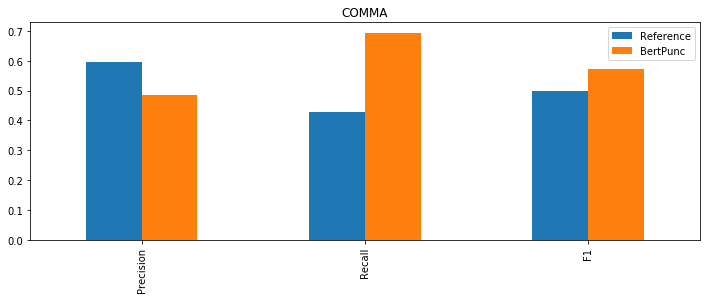

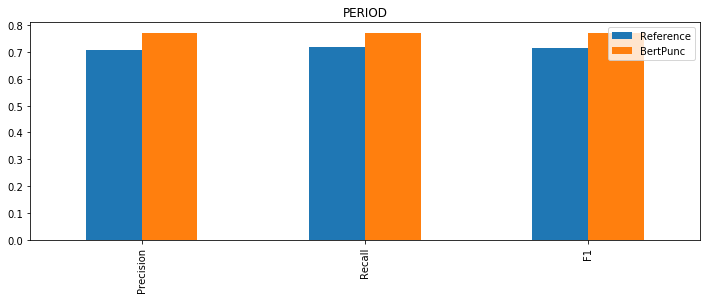

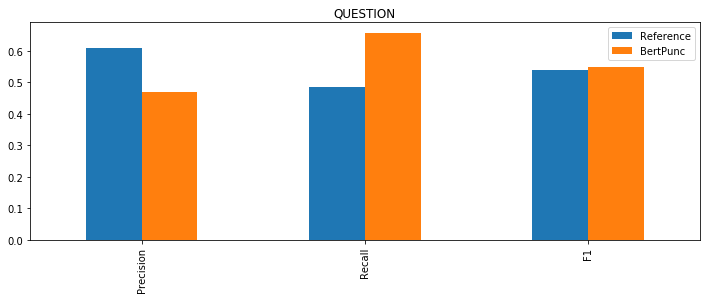

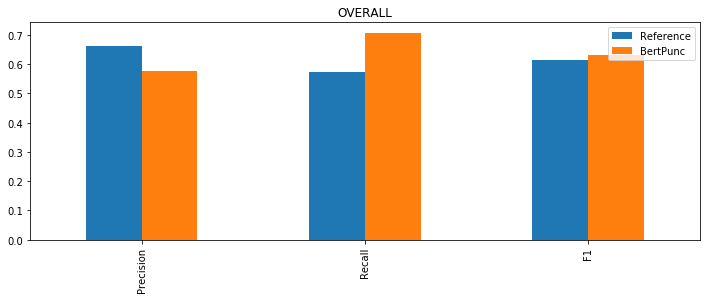

In [67]:
for col in ref.columns:
    pd.DataFrame({'Reference': ref_test_asr[col], 'BertPunc': eval_test_asr[col]}).plot.bar(
        title=col, figsize=(12, 4))